In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import ensembles
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use("seaborn")

## 1. Минимальная предобработка данных

По-хорошему, здесь многие признаки стоило бы относить к категориальным.  
Но минимальная предобработка, так минимальная.

In [14]:
train_data = pd.read_csv("train_data.csv")
train_target = pd.read_csv("train_target.csv")

In [15]:
train_data.head(5)

,index,id,date,bedrooms_number,batchrooms_number,square_footage_home,square_footage_lot,floors_number,has_waterfront,has_been_viewed,condition_quality,housing_unity_grade,square_footage_except_basement,square_footage_only_basement,build_year,renovation_year,coordinate_latitude,coordinate_longitude,square_footage_home_old,square_footage_lot_old
0,0,16530,2014-05-02,2,2.00,1350,2560,1.0,0,0,3,8,1350,0,1976,0,200.6344,4.893,1790,2560
1,1,3651,2014-05-02,3,1.75,1800,23103,1.0,0,0,3,7,1800,0,1968,0,200.6517,5.094,1410,18163
2,2,13568,2014-05-02,3,1.75,2240,10578,2.0,0,0,5,8,1550,690,1923,0,200.6954,4.708,1570,10578
3,3,20352,2014-05-02,4,2.00,1820,5000,1.5,0,1,3,7,1640,180,1945,0,200.6815,4.731,2060,5000
4,4,10524,2014-05-02,4,1.75,1560,8700,1.0,0,0,4,7,1560,0,1967,0,200.7274,4.819,2080,8000


In [16]:
train_target.head(5)

,index,price
0,0,340.0
1,1,289.0
2,2,755.0
3,3,655.0
4,4,387.5


In [17]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   17280 non-null  int64  
 1   price   17280 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 270.1 KB


In [18]:
train_data.drop("id", inplace=True, axis=1)

In [19]:
train_data["date"] = pd.to_datetime(train_data['date'])

In [20]:
train_data["year"] = train_data["date"].dt.year
train_data["month"] = train_data["date"].dt.month
train_data["day"] = train_data["date"].dt.day

In [21]:
train_data.drop("date", inplace=True, axis=1)

In [22]:
train_data.head(3)

,index,bedrooms_number,batchrooms_number,square_footage_home,square_footage_lot,floors_number,has_waterfront,has_been_viewed,condition_quality,housing_unity_grade,...,square_footage_only_basement,build_year,renovation_year,coordinate_latitude,coordinate_longitude,square_footage_home_old,square_footage_lot_old,year,month,day
0,0,2,2.00,1350,2560,1.0,0,0,3,8,...,0,1976,0,200.6344,4.893,1790,2560,2014,5,2
1,1,3,1.75,1800,23103,1.0,0,0,3,7,...,0,1968,0,200.6517,5.094,1410,18163,2014,5,2
2,2,3,1.75,2240,10578,2.0,0,0,5,8,...,690,1923,0,200.6954,4.708,1570,10578,2014,5,2


In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_data.values, train_target["price"].values,
                                                    train_size=0.7, random_state=42)

## 2. Случайный лес


### 2.1 Зависимость RMSE от количества деревьев и размерности подвыборки признаков

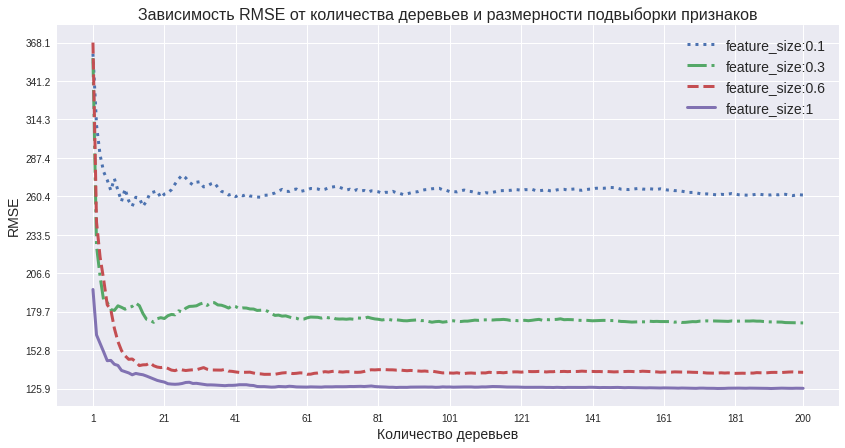

In [33]:
n_estimators = 200
feature_size = [0.1, 0.3, 0.6, 1]
ls = [":", "-.", "--", "-"]
min_score = float("+inf")
max_score = float("-inf")
plt.figure(figsize=(14, 7))
for l, f in zip(ls, feature_size):
    model = ensembles.RandomForestMSE(n_estimators=n_estimators, feature_subsample_size=f)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test, scorer=mean_squared_error)
    rmse = [i ** 0.5 for i in model.score]
    plt.plot(np.arange(1, n_estimators + 1), rmse,
             label=f"feature_size:{f}", ls=l, lw=3)
    min_score = min(min_score, *rmse)
    max_score = max(max_score, *rmse)
plt.xticks(list(range(1, n_estimators, n_estimators//10))+[n_estimators])
plt.yticks(np.linspace(min_score, max_score, 10))
plt.title("Зависимость RMSE от количества деревьев и размерности подвыборки признаков", fontsize=16)
plt.xlabel("Количество деревьев", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("21.pdf")
plt.show()

### 2.2 Зависимость RMSE от количества и глубины деревьев

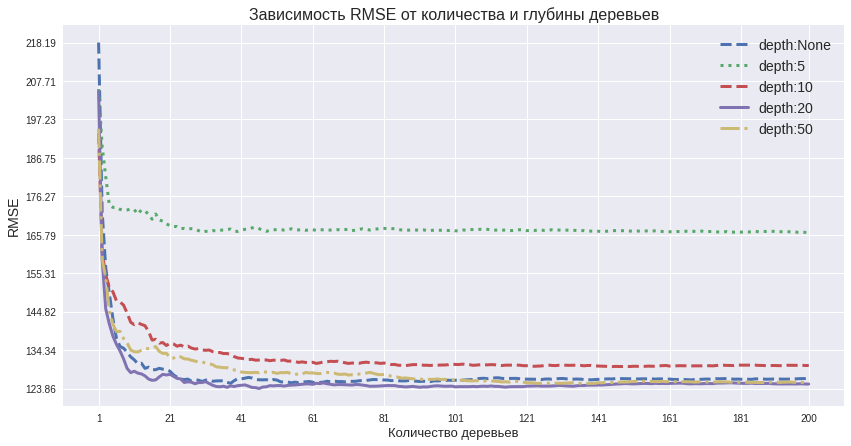

In [34]:
n_estimators = 200
depth = [None, 5, 10, 20, 50]
ls = ["--", ":", "--", "-", "-."]
min_score = float("+inf")
max_score = float("-inf")

plt.figure(figsize=(14, 7))
for l, d in zip(ls, depth):
    model = ensembles.RandomForestMSE(n_estimators=n_estimators, feature_subsample_size=1, max_depth=d)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test, scorer=mean_squared_error)
    rmse = [i ** 0.5 for i in model.score]
    plt.plot(np.arange(1, n_estimators+1), rmse, label=f"depth:{d}", ls=l, lw=3)
    min_score = min(min_score, *rmse)
    max_score = max(max_score, *rmse)
plt.xticks(list(range(1, n_estimators, n_estimators//10))+[n_estimators])
plt.yticks(np.linspace(min_score, max_score, 10))
plt.title("Зависимость RMSE от количества и глубины деревьев", fontsize=16)
plt.xlabel("Количество деревьев", fontsize=13)
plt.ylabel("RMSE", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("22.pdf")
plt.show()

## 3. Градиентный бустинг

### 3.1 Зависимость RMSE от количества деревьев и размерности подвыборки признаков

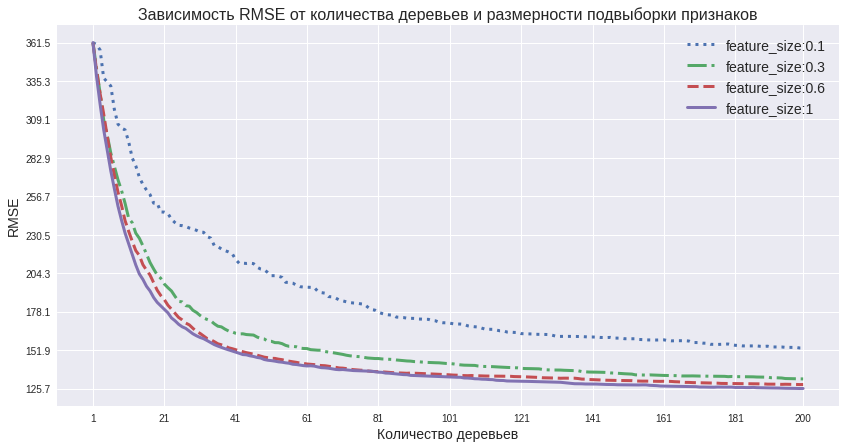

In [35]:
n_estimators = 200
feature_size = [0.1, 0.3, 0.6, 1]
ls = [":", "-.", "--", "-"]
min_score = float("+inf")
max_score = float("-inf")
plt.figure(figsize=(14, 7))
for l, f in zip(ls, feature_size):
    model = ensembles.GradientBoostingMSE(n_estimators=n_estimators, feature_subsample_size=f)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test, scorer=mean_squared_error)
    rmse = [i ** 0.5 for i in model.score]
    plt.plot(np.arange(1, n_estimators + 1), rmse,
             label=f"feature_size:{f}", ls=l, lw=3)
    min_score = min(min_score, *rmse)
    max_score = max(max_score, *rmse)
plt.xticks(list(range(1, n_estimators, n_estimators//10))+[n_estimators])
plt.yticks(np.linspace(min_score, max_score, 10))
plt.title("Зависимость RMSE от количества деревьев и размерности подвыборки признаков", fontsize=16)
plt.xlabel("Количество деревьев", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("31.pdf")
plt.show()

### 3.2 Зависимость RMSE от количества и глубины деревьев

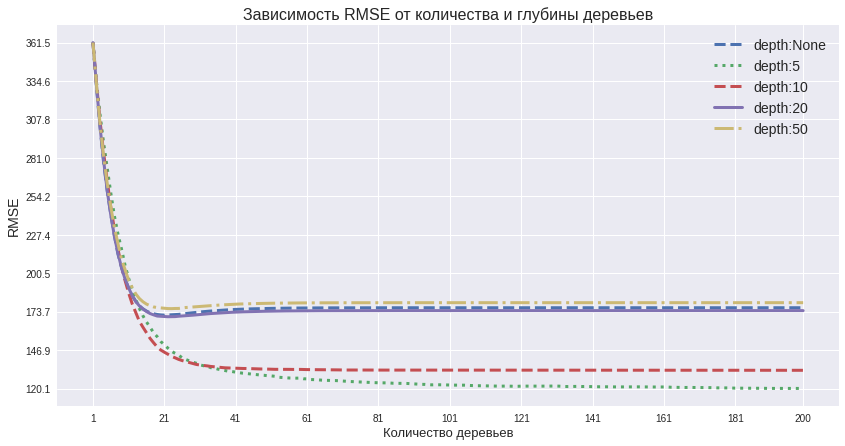

In [40]:
n_estimators = 200
depth = [None, 5, 10, 20, 50]
ls = ["--", ":", "--", "-", "-."]
min_score = float("+inf")
max_score = float("-inf")

plt.figure(figsize=(14, 7))
for l, d in zip(ls, depth):
    model = ensembles.GradientBoostingMSE(n_estimators=n_estimators, feature_subsample_size=1, max_depth=d)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test, scorer=mean_squared_error)
    rmse = [i ** 0.5 for i in model.score]
    plt.plot(np.arange(1, n_estimators+1), rmse, label=f"depth:{d}", ls=l, lw=3)
    min_score = min(min_score, *rmse)
    max_score = max(max_score, *rmse)
plt.xticks(list(range(1, n_estimators, n_estimators//10))+[n_estimators])
plt.yticks(np.linspace(min_score, max_score, 10))
plt.title("Зависимость RMSE от количества и глубины деревьев", fontsize=16)
plt.xlabel("Количество деревьев", fontsize=13)
plt.ylabel("RMSE", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("32.pdf")
plt.show()

### 3.3 Зависимость RMSE от количества деревьев и скорости обученияGradientBoostingMSE

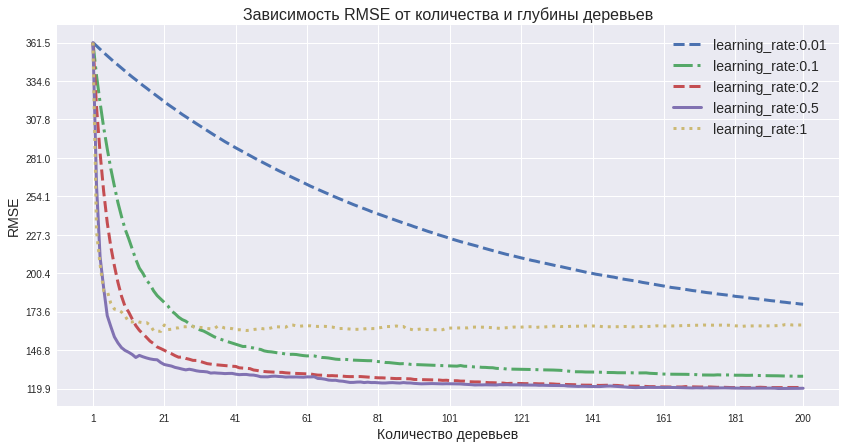

In [38]:
n_estimators = 200
learning_rate = [0.01, 0.1, 0.2, 0.5, 1]
ls = ["--", "-.", "--", "-", ":"]
min_score = float("+inf")
max_score = float("-inf")

plt.figure(figsize=(14, 7))
for l, l_r in zip(ls, learning_rate):
    model = ensembles.GradientBoostingMSE(
        n_estimators=n_estimators, feature_subsample_size=1, learning_rate=l_r)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test, scorer=mean_squared_error)
    rmse = [i ** 0.5 for i in model.score]
    plt.plot(np.arange(1, n_estimators+1), rmse, label=f"learning_rate:{l_r}", ls=l, lw=3)
    min_score = min(min_score, *rmse)
    max_score = max(max_score, *rmse)
plt.xticks(list(range(1, n_estimators, n_estimators//10))+[n_estimators])
plt.yticks(np.linspace(min_score, max_score, 10))
plt.title("Зависимость RMSE от количества и глубины деревьев", fontsize=16)
plt.xlabel("Количество деревьев", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("33.pdf")
plt.show()